<a href="https://colab.research.google.com/github/AnnaBujniewicz/semester_project/blob/main/NASDAQ_100_exploration_UML_.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>



This notebook will explore the nasdaq 100 companies.



In [ ]:
! pip install yfinance > /dev/null 2>&1
! mkdir hist

In [ ]:
# Load packages
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd
import yfinance as yf
import os, contextlib
import shutil
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
import umap
from sklearn.preprocessing import StandardScaler
from sklearn.impute import SimpleImputer

#Load information for the companies for different analysis

In [ ]:
#load company info
wiki=pd.read_html('https://en.wikipedia.org/wiki/NASDAQ-100')

In [ ]:
n100_list = wiki[3]
#creat df from the company info
n100 = n100_list
n100.head()

,Company,Ticker,GICS Sector,GICS Sub-Industry
0,Activision Blizzard,ATVI,Communication Services,Interactive Home Entertainment
1,Adobe Inc.,ADBE,Information Technology,Application Software
2,Advanced Micro Devices,AMD,Information Technology,Semiconductors
3,Alexion Pharmaceuticals,ALXN,Health Care,Pharmaceuticals
4,Align Technology,ALGN,Health Care,Health Care Supplies


In [ ]:
#load thickers
ticker_list = list(n100["Ticker"])

In [ ]:
#load stock prices
dataframes = {}
df = pd. DataFrame()
for tick in ticker_list:
  dataframes[tick] = yf.download(tick, 
                      start='2019-01-01', 
                      end='2020-11-30', 
                      progress=False)
  df[tick] = dataframes[tick].iloc[:,3]

In [ ]:
#the close price which we will work with
df.head()

,ATVI,ADBE,AMD,ALXN,ALGN,GOOGL,GOOG,AMZN,AEP,AMGN,ADI,ANSS,AAPL,AMAT,ASML,TEAM,ADSK,ADP,BIDU,BIIB,BKNG,AVGO,CDNS,CDW,CERN,CHTR,CHKP,CTAS,CSCO,CTSH,CMCSA,CPRT,COST,CSX,DXCM,DOCU,DLTR,EBAY,EA,EXC,...,MELI,MCHP,MU,MSFT,MRNA,MDLZ,MNST,NTES,NFLX,NVDA,NXPI,ORLY,OKTA,PCAR,PAYX,PYPL,PTON,PEP,PDD,QCOM,REGN,ROST,SGEN,SIRI,SWKS,SPLK,SBUX,SNPS,TMUS,TSLA,TXN,TCOM,VRSN,VRSK,VRTX,WBA,WDAY,XEL,XLNX,ZM
Date,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
2019-01-02,47.029999,224.570007,18.830000,98.050003,202.119995,1054.680054,1045.849976,1539.130005,72.940002,191.899994,85.919998,143.009995,39.480000,33.480000,156.300003,89.029999,128.960007,130.139999,162.250000,304.690002,1721.699951,253.509995,43.230000,79.169998,51.869999,287.989990,103.500000,167.490005,42.950001,63.090000,34.369999,47.680000,204.759995,61.950001,115.180000,40.820000,91.199997,28.850000,80.370003,44.070000,...,298.010010,71.349998,32.750000,101.120003,15.330000,39.889999,48.759998,45.948002,267.660004,136.220001,75.029999,341.149994,63.259998,57.860001,65.070000,85.750000,NaN,109.279999,22.209999,57.400002,372.440002,83.779999,57.490002,5.90,67.959999,103.320000,64.320000,84.050003,65.260002,62.023998,94.449997,27.590000,147.759995,108.650002,164.080002,68.040001,159.740005,48.220001,86.849998,NaN
2019-01-03,45.360001,215.699997,17.049999,100.209999,184.779999,1025.469971,1016.059998,1500.280029,72.769997,188.979996,80.730003,137.639999,35.547501,31.540001,147.679993,84.480003,121.849998,126.209999,154.710007,307.000000,1663.119995,230.960007,41.529999,77.129997,50.700001,287.500000,102.349998,164.809998,41.070000,61.099998,34.639999,46.889999,200.419998,60.980000,112.260002,38.830002,90.760002,28.320000,78.709999,44.119999,...,296.589996,66.320000,31.000000,97.400002,15.500000,39.740002,48.000000,44.180000,271.200012,127.989998,71.970001,346.130005,59.560001,56.520000,63.970001,82.089996,NaN,108.260002,21.520000,55.700001,372.079987,83.080002,56.369999,5.94,60.720001,100.809998,61.529999,81.110001,65.019997,60.071999,88.879997,26.959999,142.589996,105.330002,163.729996,67.330002,154.020004,48.029999,83.580002,NaN
2019-01-04,47.169998,226.190002,19.000000,106.000000,186.710007,1078.069946,1070.709961,1575.390015,73.440002,195.440002,82.690002,143.660004,37.064999,33.700001,154.070007,87.089996,128.279999,131.240005,160.949997,318.329987,1717.550049,233.229996,43.259998,77.879997,52.230000,302.739990,105.349998,172.559998,42.919998,63.700001,35.810001,48.560001,206.240005,62.790001,116.239998,40.900002,92.889999,28.969999,84.419998,44.619999,...,315.329987,69.010002,32.700001,101.930000,16.959999,40.840000,49.790001,45.950001,297.570007,136.190002,75.449997,341.820007,63.150002,59.029999,66.199997,86.269997,NaN,110.480003,22.690001,56.599998,397.549988,85.339996,59.540001,6.17,63.630001,108.040001,63.570000,83.900002,67.489998,63.537998,92.900002,28.549999,148.970001,109.980003,172.699997,69.570000,163.350006,48.500000,87.449997,NaN
2019-01-07,48.500000,229.259995,20.570000,107.940002,189.919998,1075.920044,1068.390015,1629.510010,73.029999,198.070007,83.209999,147.320007,36.982498,34.299999,157.589996,92.709999,132.720001,130.529999,162.600006,322.399994,1711.819946,237.979996,43.419998,77.570000,51.930000,301.470001,104.870003,172.850006,43.209999,63.599998,35.430000,48.830002,207.000000,62.450001,129.949997,41.689999,97.959999,29.469999,87.589996,44.700001,...,328.940002,71.029999,34.000000,102.059998,16.270000,41.119999,49.730000,47.897999,315.339996,143.399994,76.010002,339.690002,66.269997,58.959999,65.849998,86.930000,NaN,109.529999,23.209999,56.439999,396.630005,88.930000,62.919998,6.22,64.489998,112.900002,63.570000,85.760002,68.440002,66.991997,94.500000,29.180000,151.399994,110.089996,175.850006,69.970001,163.500000,48.290001,89.760002,NaN
2019-01-08,49.970001,232.679993,20.750000,108.610001,192.949997,1085.369995,1076.280029,1656.579956,73.930000,200.610001,85.239998,148.050003,37.687500,32.910000,156.429993,94.820000,133.8699

In [ ]:
#rename the index
df.index.name = 'date'

In [ ]:
#load open prices
open = yf.download(ticker_list, start='2019-10-30', end='2020-12-01')['Open']

[*********************100%***********************]  102 of 102 completed


visualization of the prices

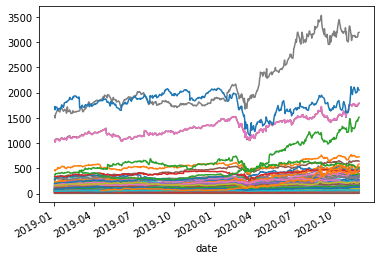

In [ ]:
#visualization for the companies through time
df.plot.line(legend=False)

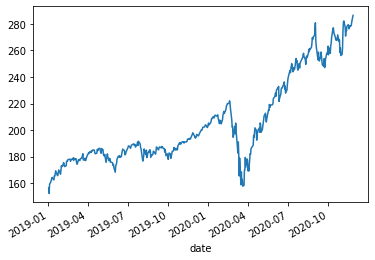

In [ ]:
#average of the 100 how it is developing
df['average'] = df.mean(axis=1)
df['average'].plot.line()

In [ ]:
stock_returns = df.apply(np.log).diff(1)

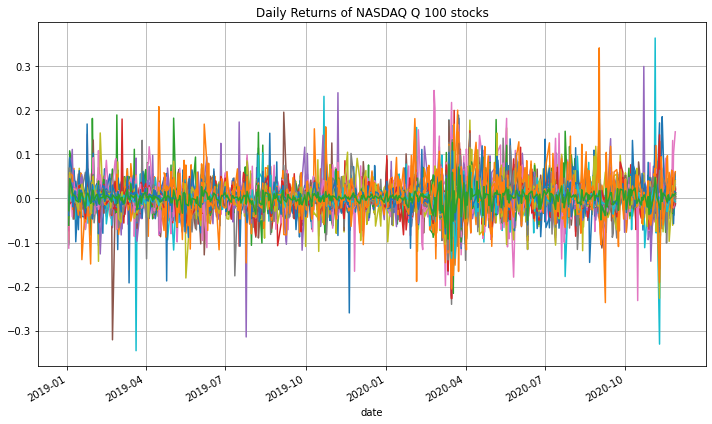

In [ ]:
#plot the returns development
stock_returns.plot(legend=0, figsize=(10,6), grid=True, title='Daily Returns of NASDAQ Q 100 stocks')
plt.tight_layout()

In [ ]:
stock_returns.describe()

,ATVI,ADBE,AMD,ALXN,ALGN,GOOGL,GOOG,AMZN,AEP,AMGN,ADI,ANSS,AAPL,AMAT,ASML,TEAM,ADSK,ADP,BIDU,BIIB,BKNG,AVGO,CDNS,CDW,CERN,CHTR,CHKP,CTAS,CSCO,CTSH,CMCSA,CPRT,COST,CSX,DXCM,DOCU,DLTR,EBAY,EA,EXC,...,MCHP,MU,MSFT,MRNA,MDLZ,MNST,NTES,NFLX,NVDA,NXPI,ORLY,OKTA,PCAR,PAYX,PYPL,PTON,PEP,PDD,QCOM,REGN,ROST,SGEN,SIRI,SWKS,SPLK,SBUX,SNPS,TMUS,TSLA,TXN,TCOM,VRSN,VRSK,VRTX,WBA,WDAY,XEL,XLNX,ZM,average
count,481.000000,481.000000,481.000000,481.000000,481.000000,481.000000,481.000000,481.000000,481.000000,481.000000,481.000000,481.000000,481.000000,481.000000,481.000000,481.000000,481.000000,481.000000,481.000000,481.000000,481.000000,481.000000,481.000000,481.000000,481.000000,481.000000,481.000000,481.000000,481.000000,481.000000,481.000000,481.000000,481.000000,481.000000,481.000000,481.000000,481.000000,481.000000,481.000000,481.000000,...,481.000000,481.000000,481.000000,481.000000,481.000000,481.000000,481.000000,481.000000,481.000000,481.000000,481.000000,481.000000,481.000000,481.000000,481.000000,296.000000,481.000000,481.000000,481.000000,481.000000,481.000000,481.000000,481.000000,481.000000,481.000000,481.000000,481.000000,481.000000,481.000000,481.000000,481.000000,481.000000,481.000000,481.000000,481.000000,481.000000,481.000000,481.000000,407.000000,481.000000
mean,0.001056,0.001566,0.003186,0.000485,0.001779,0.001096,0.001121,0.001519,0.000316,0.000329,0.000981,0.001741,0.002251,0.001879,0.002141,0.001918,0.001558,0.000619,-0.000315,-0.000464,0.000366,0.000922,0.002062,0.001066,0.000742,0.001669,0.000303,0.001597,-0.000012,0.000452,0.000851,0.001834,0.001331,0.000806,0.002113,0.003566,0.000388,0.001198,0.000904,-0.000113,...,0.001295,0.001400,0.001570,0.004396,0.000759,0.001134,0.001473,0.001263,0.002826,0.001561,0.000544,0.002738,0.000866,0.000751,0.001876,0.004873,0.000582,0.003887,0.001910,0.000670,0.000557,0.002243,0.000217,0.001445,0.001415,0.000889,0.002051,0.001463,0.004668,0.001083,0.000447,0.000635,0.001250,0.000672,-0.001157,0.000702,0.000703,0.000955,0.004985,0.001254
std,0.023906,0.024251,0.036404,0.024530,0.038449,0.020499,0.020541,0.020212,0.018485,0.019671,0.026379,0.023268,0.024153,0.031611,0.025432,0.026830,0.026478,0.022148,0.025792,0.037501,0.026136,0.027322,0.024027,0.025398,0.016965,0.018570,0.017562,0.025537,0.022130,0.024437,0.019299,0.021865,0.014932,0.023306,0.032637,0.033030,0.025171,0.019939,0.023439,0.023236,...,0.031839,0.032852,0.021925,0.050867,0.016896,0.020221,0.026025,0.026035,0.032266,0.031729,0.021498,0.029669,0.019163,0.023336,0.026212,0.047013,0.017886,0.039078,0.029268,0.023451,0.027824,0.029185,0.021809,0.029946,0.030163,0.022345,0.022298,0.020677,0.045986,0.023046,0.029313,0.020382,0.018835,0.024614,0.025064,0.027960,0.018962,0.028741,0.046817,0.017356
min,-0.112462,-0.159525,-0.158280,-0.107274,-0.314546,-0.123685,-0.117667,-0.082535,-0.123103,-0.086220,-0.181700,-0.131797,-0.137708,-0.227624,-0.190545,-0.095016,-0.127864,-0.165495,-0.180553,-0.345742,-0.119205,-0.222055,-0.134653,-0.152523,-0.064214,-0.154654,-0.100780,-0.184656,-0.118615,-0.188498,-0.087358,-0.151511,-0.065238,-0.169017,-0.187498,-0.159155,-0.173398,-0.095770,-0.142777,-0.175415,...,-0.226830,-0.220878,-0.159453,-0.198047,-0.121374,-0.082664,-0.121326,-0.118095,-0.203979,-0.215431,-0.167529,-0.110354,-0.079211,-0.216667,-0.172259,-0.226717,-0.121358,-0.259912,-0.161875,-0.110813,-0.227651,-0.142469,-0.149641,-0.200805,-0.185260,-0.176788,-0.141438,-0.118882,-0.236518,-0.125855,-0.106380,-0.130485,-0.112936,-0.231875,-0.137025,-0.136439,-0.135726,-0.187258,-0.190800,-0.119149
25%,-0.011655,-0.008410,-0.015285,-0.013574,-0.014308,-0.006582,-0.006450,-0.008149,-0.005979,-0.008366,-0.010936,-0.008966,-0.007483,-0.011660,-0.008964,-0.013016,-0.009658,-0.006934,-0.013039,-0.010884,-0.010824,-0.009748,-0.008401,-0.008490,-0.006532,-0.005717,-0.006242,-0.007074,-0.008123,-0.007913,-0.007869,-0.005882,-0.005169,-0.008226,-0.013963,-0.010191,-0.009914,-0.008354,-0.009988,-0.008231,...,-0.013855,-0.015293,-0.007752,-0.023158,

#Preparing for unsupervised machine learning

In [ ]:
#create a time period
q1 = df.loc['2020-01-01':'2020-04-30']

In [ ]:
# Create empty dataframe
# add the tickers into the dataframe
stocks = pd.DataFrame(data=None, columns=['ticker', 'company', 'sector', 'industry'])
stocks['ticker']=q1.columns
stocks.head()

,ticker,company,sector,industry
0,ATVI,NaN,NaN,NaN
1,ADBE,NaN,NaN,NaN
2,AMD,NaN,NaN,NaN
3,ALXN,NaN,NaN,NaN
4,ALGN,NaN,NaN,NaN


In [ ]:
# add sector

for i in range(len(stocks)):
  for j in range(len(n100['Ticker'])):
    if stocks['ticker'][i] == n100['Ticker'][j]:
      stocks['sector'][i] = n100['GICS Sector'][j]
    else: continue

# add industry

for i in range(len(stocks)):
  for j in range(len(n100['Ticker'])):
    if stocks['ticker'][i] == n100['Ticker'][j]:
      stocks['industry'][i] = n100['GICS Sub-Industry'][j]
    else: continue

#add company names
for i in range(len(stocks)):
  for j in range(len(n100['Ticker'])):
    if stocks['ticker'][i] == n100['Ticker'][j]:
      stocks['company'][i] = n100['Company'][j]
    else: continue

In [ ]:
stocks['return'] = [(q1[i]['2020-04-30']/q1[i]['2020-01-02'] - 1) for i in stocks['ticker']]

In [ ]:
#displaying the returns for different companies 
print(len(stocks[stocks['return'] > 0]))
stocks[stocks['return'] > 0]

38


,ticker,company,sector,industry,return
0,ATVI,Activision Blizzard,Communication Services,Interactive Home Entertainment,0.086615
1,ADBE,Adobe Inc.,Information Technology,Application Software,0.057441
2,AMD,Advanced Micro Devices,Information Technology,Semiconductors,0.067006
7,AMZN,Amazon.com,Consumer Discretionary,Internet & Direct Marketing Retail,0.303470
11,ANSS,ANSYS,Information Technology,Application Software,0.008629
15,TEAM,Atlassian,Information Technology,Application Software,0.265381
19,BIIB,Biogen,Health Care,Biotechnology,0.008802
22,CDNS,Cadence Design Systems,Information Technology,Application Software,0.135638
25,CHTR,"Charter Communications, Inc.",Communication Services,Cable & Satellite,0.009787
32,COST,Costco Wholesale Corporation,Consumer Staples,Hypermarkets & Super Centers,0.039487


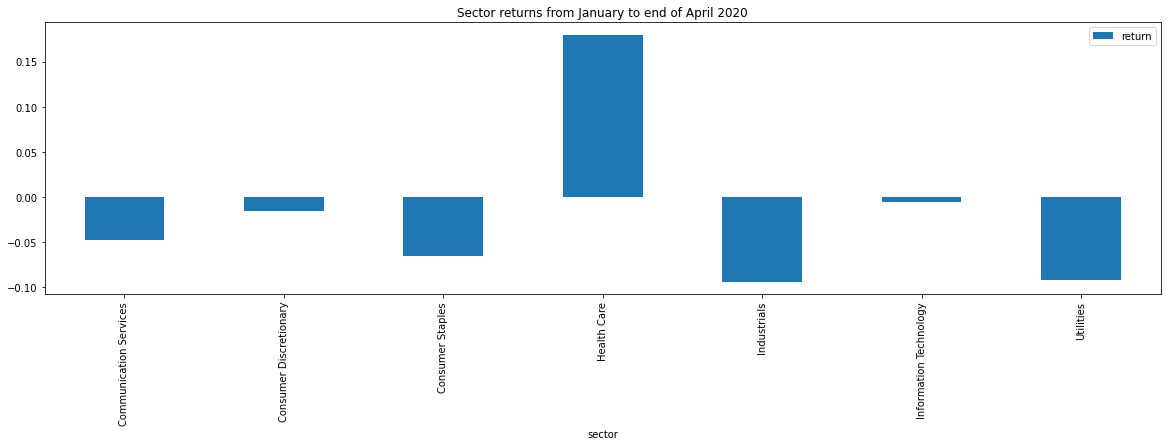

In [ ]:
#visualizing the returns in accordance to the sectors
sector_return = stocks.groupby('sector').mean()
sector_return.plot.bar(figsize=(20,5))
plt.title('Sector returns from January to end of April 2020')
plt.savefig('sectors.png', bbox_inches='tight')

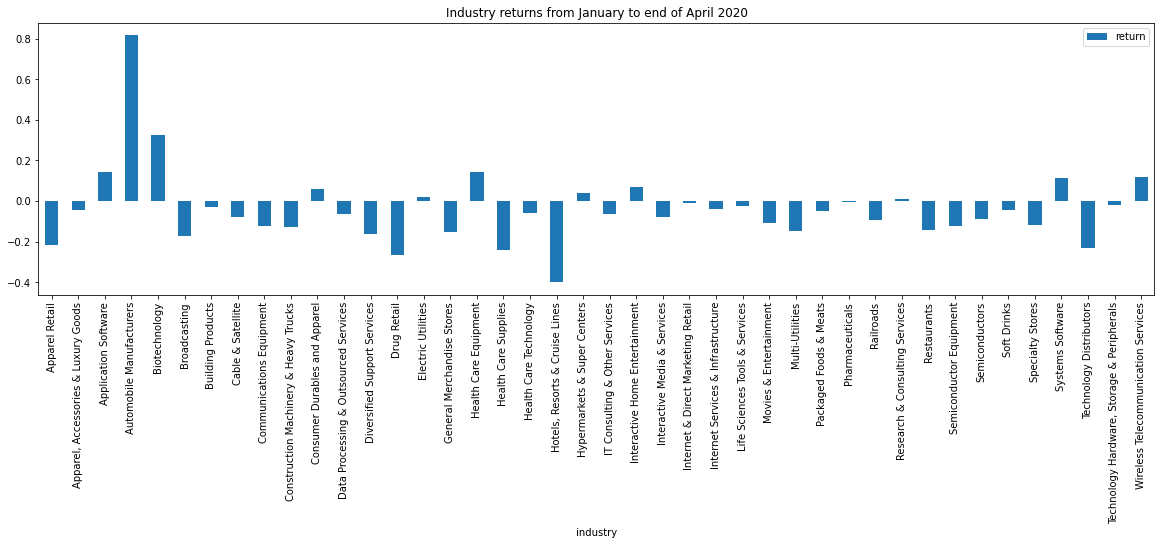

In [ ]:
#visualizing the returns according to the industry
industry_return = stocks.groupby('industry').mean()
industry_return.plot.bar(figsize=(20,5))
plt.title('Industry returns from January to end of April 2020')
plt.savefig('industries.png', bbox_inches='tight')

In [ ]:
#creating a column where we display positive, neutral or ngeative the return
stocks['return_class'] = 'tbd'
for i in range(len(stocks)):
  if stocks['return'][i] > 0:
    stocks['return_class'][i] = 'positive'
  elif stocks['return'][i] < 0:
    stocks['return_class'][i] = 'negative'
  else: stocks['return_class'][i] = 'neutral'

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  import sys


In [ ]:
stocks.head()

,ticker,company,sector,industry,return,return_class
0,ATVI,Activision Blizzard,Communication Services,Interactive Home Entertainment,0.086615,positive
1,ADBE,Adobe Inc.,Information Technology,Application Software,0.057441,positive
2,AMD,Advanced Micro Devices,Information Technology,Semiconductors,0.067006,positive
3,ALXN,Alexion Pharmaceuticals,Health Care,Pharmaceuticals,-0.003431,negative
4,ALGN,Align Technology,Health Care,Health Care Supplies,-0.242633,negative


In [ ]:
#count the different classes
stocks['return_class'].value_counts()

negative    65
positive    38
Name: return_class, dtype: int64

In [ ]:
#get all the remaning information for the companies 
symbols_filtered = [x for x in  ticker_list]
len(symbols_filtered)

102

In [ ]:
#define which of the fundamental to keep
ts = yf.Ticker("TSLA")
all = list(ts.info.keys())
to_keep = ['beta', 'enterpriseToEbitda', 'enterpriseToRevenue', 'forwardEps', 'trailingEps', 'forwardPE', 'trailingPE', 'fullTimeEmployees', 'priceToBook', 'profitMargins']
to_drop = [field for field in all if field not in to_keep]

In [ ]:
#get the statistics
n100_stats = {}
for symbol in symbols_filtered:
    ticker1 = yf.Ticker(symbol)
    temp = ticker1.info
 
    n100_stats[symbol] = temp

In [ ]:
#combine all the stats valuation tables into a single data frame
combined_stats = pd.DataFrame(n100_stats)

#filter not needed rows
#drope the missing values
combined_stats.drop(to_drop, inplace=True)
combined_stats.drop('fax', inplace=True)

In [ ]:
combined_stats

,ATVI,ADBE,AMD,ALXN,ALGN,GOOGL,GOOG,AMZN,AEP,AMGN,ADI,ANSS,AAPL,AMAT,ASML,TEAM,ADSK,ADP,BIDU,BIIB,BKNG,AVGO,CDNS,CDW,CERN,CHTR,CHKP,CTAS,CSCO,CTSH,CMCSA,CPRT,COST,CSX,DXCM,DOCU,DLTR,EBAY,EA,EXC,...,MELI,MCHP,MU,MSFT,MRNA,MDLZ,MNST,NTES,NFLX,NVDA,NXPI,ORLY,OKTA,PCAR,PAYX,PYPL,PTON,PEP,PDD,QCOM,REGN,ROST,SGEN,SIRI,SWKS,SPLK,SBUX,SNPS,TMUS,TSLA,TXN,TCOM,VRSN,VRSK,VRTX,WBA,WDAY,XEL,XLNX,ZM
fullTimeEmployees,9080,NaN,11400,3082,14530,132121,132121,1125300,17408,23400,15900,4500,147000,24000,24749,4907,10100,58000,37779,7400,23000,21000,8100,9980,27400,95100,5258,40000,77500,283100,190000,7600,156000,19000,3900,3909,56900,13300,9800,32713,...,9703,18000,40000,163000,1100,80000,1273,20797,8600,13775,29400,76027,2604,27000,15600,23200,4404,267000,5828,41000,8314,92500,1605,4534,10000,5800,349000,15036,53000,48016,29768,44300,872,9060,3000,223000,12400,11273,4891,3871
beta,0.671916,0.967979,2.26719,1.25459,1.67507,0.997375,0.997375,1.20105,0.212598,0.754855,1.32178,1.22257,1.29764,1.48346,0.88372,0.977777,1.44409,0.71916,1.07506,0.492388,1.21102,1.02835,1.04409,1.10656,0.745931,1.01155,0.650393,1.48871,0.937532,1.13123,1.01732,1.02887,0.674015,1.20315,0.844619,0.902737,0.774278,1.25932,0.893963,0.39895,...,1.65459,1.69921,1.36535,0.823097,1.83408,0.617847,1.10446,0.585301,0.932283,1.46877,1.53543,0.993175,0.989561,1.05144,0.910761,1.10341,None,0.579527,1.55337,1.36168,0.315485,0.920209,1.09344,1.14068,1.221,1.49291,0.805774,1.09764,0.529658,2.15118,1.07769,1.36168,0.814698,0.775853,0.785301,0.51811,1.48609,0.237795,0.985301,None
trailingPE,32.5904,46.1791,124.268,36.259,24.3165,33.8661,33.8514,95.2263,21.5614,18.5434,45.0396,82.7006,40.4543,22.0153,70.0848,NaN,158.371,30.585,16.849,8.06044,66.1166,69.1925,35.372,25.9941,30.6682,52.454,22.7742,39.6478,18.1174,30.3744,23.4978,44.6335,38.6838,25.2153,152.84,NaN,26.6831,6.96949,32.0036,17.3745,...,NaN,59.1224,31.6948,35.88,NaN,27.5932,41.6764,14.3605,87.3272,85.3686,NaN,20.2592,NaN,21.0439,31.802,88.3774,NaN,29.3663,NaN,33.7035,17.7054,142.802,66.1405,26.9915,31.85,NaN,135.418,60.7119,46.468,1349.27,31.0676,NaN,31.2175,51.524,23.1615,76.8401,NaN,23.7344,57.9126,234.413
forwardPE,26.2288,37.802,50.1148,12.0556,63.9976,28.6005,28.5835,71.7228,17.9461,13.5247,23.3381,51.6028,30.5035,16.0708,41.5434,164.697,59.06,27.8357,20.7524,9.70896,39.9152,15.6879,47.5366,19.6995,24.3727,31.3382,19.2066,35.9207,13.2789,20.6423,18.0069,36.3571,34.3464,20.9584,113.76,198.482,17.4258,13.5811,24.094,14.2155,...,526.799,19.3975,10.4562,29.7751,10.1625,20.734,35.2977,22.169,59.7492,44.5944,19.5104,19.541,25426,15.9778,29.6752,51.8142,-156.412,24.5124,323.036,19.1623,13.1458,26.9912,3502.8,23.5926,17.7767,-653.423,31.3724,36.4613,48.1607,183.768,28.201,None,37.0548,38.2302,20.5156,7.68401,82.6241,22.4478,42.4461,112.816
enterpriseToRevenue,8.846,18.517,12.619,5.947,18.191,6.293,6.29,4.778,4.988,6.234,10.569,20.044,8.332,4.585,None,33.314,18.525,5.243,None,2.939,10.394,8.882,14.844,1.238,4.443,4.995,8.267,5.64,3.634,2.55,3.245,13.354,0.943,7.844,19.07,32.041,1.36,3.314,6.594,2.426,...,24.767,8.563,3.862,11.059,155.148,3.883,10.673,None,10.439,21.708,6.033,3.352,42.102,1.864,8.463,13.299,18.238,3.5,None,7.541,5.48,3.555,16.061,4.467,7.329,12.376,6.222,10.611,4.395,23.815,11.062,None,20.184,13.452,9.323,0.543,13.69,4.974,11.333,48.374
profitMargins,0.2889,0.40877,0.10166,0.16317,0.75995,0.20799,0.20799,0.04994,0.12852,0.29423,0.21787,0.2488,0.20914,0.21038,0.24252,-0.25816,0.11744,0.1707,0.22369,0.35633,0.15679,0.12391,0.42678,0.04077,0.14279,0.05695,0.41475,0.13902,0.21764,0.08781,0.09895,0.30391,0.025,0.26083,0.12694,-0.16828,0.0384,0.45565,0.23506,0.07142,...,-0.00124,0.11622,0.12536,0.32285,-2.42342,0.11731,0.26989,0.20305,0.11781,0.25892,-0.01701,0.1496,-0.31379,0.07386,0.26655,0.15479,0.02016,0.1027,-0.17274,0.2209,0.34143,0.02391,0.25343,0.13282,0.24281,-0.34769,0.03947,0.18027,0.05114,0.01973,0.36236,-0.10343,0.64199,0.24334,0.44911,0.00327,-0.08136,0.12982,0.20583,0.2182
enterpriseToEbitda,23.374,47.722,76

In [ ]:
combined_stats=combined_stats.transpose()

In [ ]:
#display the data
combined_stats

,fullTimeEmployees,beta,trailingPE,forwardPE,enterpriseToRevenue,profitMargins,enterpriseToEbitda,forwardEps,trailingEps,priceToBook,address2,underlyingSymbol,underlyingExchangeSymbol,headSymbol,uuid
ATVI,9080,0.671916,32.5904,26.2288,8.846,0.2889,23.374,3.54,2.849,4.98925,NaN,NaN,NaN,NaN,NaN
ADBE,NaN,0.967979,46.1791,37.802,18.517,0.40877,47.722,13.23,10.83,18.0607,NaN,NaN,NaN,NaN,NaN
AMD,11400,2.26719,124.268,50.1148,12.619,0.10166,76.139,1.83,0.738,28.5079,NaN,NaN,NaN,NaN,NaN
ALXN,3082,1.25459,36.259,12.0556,5.947,0.16317,11.231,12.96,4.309,3.08958,NaN,NaN,NaN,NaN,NaN
ALGN,14530,1.67507,24.3165,63.9976,18.191,0.75995,98.687,8.35,21.976,13.8901,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
WBA,223000,0.51811,76.8401,7.68401,0.543,0.00327,16.45,5.19,0.519,1.67275,NaN,None,None,None,888fa4a2-1f3d-3718-83dd-229207680ca9
WDAY,12400,1.48609,NaN,82.6241,13.69,-0.08136,1110.88,2.9,-1.445,18.5975,NaN,None,None,None,ee0b6181-c505-339e-b6b1-1498fe62d99c
XEL,11273,0.237795,23.7344,22.4478,4.974,0.12982,14.184,2.97,2.809,2.54281,NaN,None,None,None,d977fcfc-aff2-3286-97db-8771b2b3be45
XLNX,4891,0.985301,57.9126,42.4461,11.333,0.20583,35.986,3.34,2.448,14.1643,NaN,None,None,None,ac08a31b-4c1b-3bd5-8258-fa0a2afa17e2


In [ ]:
#merge the stock data and the statistical dataframe together
stock_stats = stocks.merge(combined_stats, left_on='ticker', right_index=True, how='outer')
stock_stats

,ticker,company,sector,industry,return,return_class,fullTimeEmployees,beta,trailingPE,forwardPE,enterpriseToRevenue,profitMargins,enterpriseToEbitda,forwardEps,trailingEps,priceToBook,address2,underlyingSymbol,underlyingExchangeSymbol,headSymbol,uuid
0,ATVI,Activision Blizzard,Communication Services,Interactive Home Entertainment,0.086615,positive,9080,0.671916,32.5904,26.2288,8.846,0.2889,23.374,3.54,2.849,4.98925,NaN,NaN,NaN,NaN,NaN
1,ADBE,Adobe Inc.,Information Technology,Application Software,0.057441,positive,NaN,0.967979,46.1791,37.802,18.517,0.40877,47.722,13.23,10.83,18.0607,NaN,NaN,NaN,NaN,NaN
2,AMD,Advanced Micro Devices,Information Technology,Semiconductors,0.067006,positive,11400,2.26719,124.268,50.1148,12.619,0.10166,76.139,1.83,0.738,28.5079,NaN,NaN,NaN,NaN,NaN
3,ALXN,Alexion Pharmaceuticals,Health Care,Pharmaceuticals,-0.003431,negative,3082,1.25459,36.259,12.0556,5.947,0.16317,11.231,12.96,4.309,3.08958,NaN,NaN,NaN,NaN,NaN
4,ALGN,Align Technology,Health Care,Health Care Supplies,-0.242633,negative,14530,1.67507,24.3165,63.9976,18.191,0.75995,98.687,8.35,21.976,13.8901,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
98,WDAY,"Workday, Inc.",Information Technology,Application Software,-0.080975,negative,12400,1.48609,NaN,82.6241,13.69,-0.08136,1110.88,2.9,-1.445,18.5975,NaN,None,None,None,ee0b6181-c505-339e-b6b1-1498fe62d99c
99,XEL,Xcel Energy Inc.,Utilities,Electric Utilities,0.018916,positive,11273,0.237795,23.7344,22.4478,4.974,0.12982,14.184,2.97,2.809,2.54281,NaN,None,None,None,d977fcfc-aff2-3286-97db-8771b2b3be45
100,XLNX,"Xilinx, Inc.",Information Technology,Semiconductors,-0.140187,negative,4891,0.985301,57.9126,42.4461,11.333,0.20583,35.986,3.34,2.448,14.1643,NaN,None,None,None,ac08a31b-4c1b-3bd5-8258-fa0a2afa17e2
101,ZM,Zoom Video Communications,Information Technology,Application Software,0.966967,positive,3871,None,234.413,112.816,48.374,0.2182,211.164,2.99,1.439,64.3127,6th Floor,None,None,None,70f73ee5-133f-39c2-b135-16067fabfd87


In [ ]:
#creat a full statistical dataframe and deplace the None
stock_stats_full=stock_stats.replace('None',np.nan)

In [ ]:
#impute missing values
imp=SimpleImputer(missing_values=np.nan)

In [ ]:
# Check for NaN values
print(stock_stats.isna().sum().sum())

504


In [ ]:
stock_stats_full

,ticker,company,sector,industry,return,return_class,fullTimeEmployees,beta,trailingPE,forwardPE,enterpriseToRevenue,profitMargins,enterpriseToEbitda,forwardEps,trailingEps,priceToBook,address2,underlyingSymbol,underlyingExchangeSymbol,headSymbol,uuid
0,ATVI,Activision Blizzard,Communication Services,Interactive Home Entertainment,0.086615,positive,9080.0,0.671916,32.590380,26.228813,8.846,0.28890,23.374,3.54,2.849,4.989253,NaN,NaN,NaN,NaN,NaN
1,ADBE,Adobe Inc.,Information Technology,Application Software,0.057441,positive,NaN,0.967979,46.179130,37.801968,18.517,0.40877,47.722,13.23,10.830,18.060741,NaN,NaN,NaN,NaN,NaN
2,AMD,Advanced Micro Devices,Information Technology,Semiconductors,0.067006,positive,11400.0,2.267191,124.268295,50.114754,12.619,0.10166,76.139,1.83,0.738,28.507927,NaN,NaN,NaN,NaN,NaN
3,ALXN,Alexion Pharmaceuticals,Health Care,Pharmaceuticals,-0.003431,negative,3082.0,1.254593,36.258995,12.055556,5.947,0.16317,11.231,12.96,4.309,3.089579,NaN,NaN,NaN,NaN,NaN
4,ALGN,Align Technology,Health Care,Health Care Supplies,-0.242633,negative,14530.0,1.675065,24.316528,63.997600,18.191,0.75995,98.687,8.35,21.976,13.890102,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
98,WDAY,"Workday, Inc.",Information Technology,Application Software,-0.080975,negative,12400.0,1.486089,NaN,82.624140,13.690,-0.08136,1110.880,2.90,-1.445,18.597486,NaN,NaN,NaN,NaN,ee0b6181-c505-339e-b6b1-1498fe62d99c
99,XEL,Xcel Energy Inc.,Utilities,Electric Utilities,0.018916,positive,11273.0,0.237795,23.734425,22.447811,4.974,0.12982,14.184,2.97,2.809,2.542812,NaN,NaN,NaN,NaN,d977fcfc-aff2-3286-97db-8771b2b3be45
100,XLNX,"Xilinx, Inc.",Information Technology,Semiconductors,-0.140187,negative,4891.0,0.985301,57.912586,42.446110,11.333,0.20583,35.986,3.34,2.448,14.164253,NaN,NaN,NaN,NaN,ac08a31b-4c1b-3bd5-8258-fa0a2afa17e2
101,ZM,Zoom Video Communications,Information Technology,Application Software,0.966967,positive,3871.0,NaN,234.412800,112.816055,48.374,0.21820,211.164,2.99,1.439,64.312680,6th Floor,NaN,NaN,NaN,70f73ee5-133f-39c2-b135-16067fabfd87


In [ ]:
#drop rows with NaN values since PCA cannot deal with them and extrapolating affects the result
stock_stats_full = imp.fit_transform(stock_stats_full.loc[:,'fullTimeEmployees':'priceToBook'])

In [ ]:
# scale all relevant variables into a new matrix
stock_stats_scaled = StandardScaler().fit_transform(stock_stats_full)

#Unsupervised Machine Learning

##UMAP cluster analissi for the comapny indicators

In [ ]:
reducer = umap.UMAP()

In [ ]:
#UMAP with 2 components
umap_stocks = reducer.fit_transform(stock_stats_scaled)
umap_stocks.shape

(103, 2)

/usr/local/lib/python3.6/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


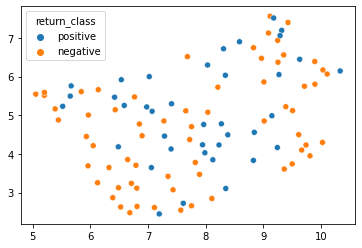

In [ ]:
#display the umap in case od the return class
sns_plot = sns.scatterplot(umap_stocks[:,0], umap_stocks[:,1], hue = stock_stats['return_class'])
figure = sns_plot.get_figure()    
figure.savefig('UMAP with 2 components')

In [ ]:
# UMAP with 2 components
reducer = umap.UMAP(n_components=2)
umap_stocks = reducer.fit_transform(stock_stats_scaled)
umap_stocks.shape

(103, 2)

/usr/local/lib/python3.6/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


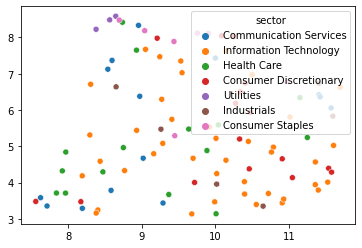

In [ ]:
#display the UMAP according to the sectors
sns_plot = sns.scatterplot(umap_stocks[:,0], umap_stocks[:,1], hue = stock_stats['sector'])
figure = sns_plot.get_figure()    
figure.savefig('UMAP with 8 components')

shows that the There is now growth distribution in different sectors if we would have a separate cluster of dots it would mean that that sector is outstand for some reason but this means taht we sould invest in cross sector


##UML for the stock prices

In [ ]:
#get ready for clustering
df_for_clustering = df.transpose()
df_for_clustering

date,2019-01-02,2019-01-03,2019-01-04,2019-01-07,2019-01-08,2019-01-09,2019-01-10,2019-01-11,2019-01-14,2019-01-15,2019-01-16,2019-01-17,2019-01-18,2019-01-22,2019-01-23,2019-01-24,2019-01-25,2019-01-28,2019-01-29,2019-01-30,2019-01-31,2019-02-01,2019-02-04,2019-02-05,2019-02-06,2019-02-07,2019-02-08,2019-02-11,2019-02-12,2019-02-13,2019-02-14,2019-02-15,2019-02-19,2019-02-20,2019-02-21,2019-02-22,2019-02-25,2019-02-26,2019-02-27,2019-02-28,...,2020-10-02,2020-10-05,2020-10-06,2020-10-07,2020-10-08,2020-10-09,2020-10-12,2020-10-13,2020-10-14,2020-10-15,2020-10-16,2020-10-19,2020-10-20,2020-10-21,2020-10-22,2020-10-23,2020-10-26,2020-10-27,2020-10-28,2020-10-29,2020-10-30,2020-11-02,2020-11-03,2020-11-04,2020-11-05,2020-11-06,2020-11-09,2020-11-10,2020-11-11,2020-11-12,2020-11-13,2020-11-16,2020-11-17,2020-11-18,2020-11-19,2020-11-20,2020-11-23,2020-11-24,2020-11-25,2020-11-27
ATVI,47.029999,45.360001,47.169998,48.500000,49.970001,50.830002,51.349998,46.540001,47.290001,46.840000,47.130001,47.380001,48.650002,47.060001,46.020000,47.270000,47.799999,46.740002,45.730000,46.310001,47.240002,46.009998,46.779999,47.840000,43.000000,43.959999,43.410000,40.110001,41.669998,44.570000,45.430000,44.599998,44.480000,42.779999,41.900002,41.500000,41.959999,42.080002,41.790001,42.139999,...,78.300003,79.989998,78.300003,78.470001,77.800003,78.209999,81.059998,81.980003,81.900002,80.349998,80.620003,80.080002,80.139999,81.940002,80.769997,81.040001,80.489998,80.959999,79.010002,77.769997,75.730003,76.400002,76.260002,79.370003,80.139999,78.809998,75.410004,75.120003,76.550003,76.709999,77.550003,77.440002,77.110001,75.500000,75.930000,76.809998,75.919998,75.230003,76.510002,78.139999
ADBE,224.570007,215.699997,226.190002,229.259995,232.679993,235.429993,237.770004,237.550003,234.559998,242.360001,241.949997,244.399994,247.509995,243.850006,245.139999,242.559998,244.949997,241.850006,238.270004,242.669998,247.820007,247.380005,254.740005,254.820007,254.350006,253.740005,257.000000,258.390015,261.369995,260.230011,260.140015,259.450012,257.809998,258.100006,257.760010,258.899994,258.619995,261.220001,262.899994,262.500000,...,478.989990,486.470001,478.980011,493.149994,490.839996,502.160004,510.890015,514.309998,506.309998,501.149994,502.820007,495.200012,494.579987,495.959991,483.600006,488.500000,475.200012,478.559998,456.970001,461.109985,447.100006,444.940002,454.019989,487.230011,496.470001,494.630005,471.140015,452.000000,467.750000,462.579987,469.339996,460.950012,467.950012,459.470001,466.410004,462.920013,460.609985,462.700012,470.079987,477.029999
AMD,18.830000,17.049999,19.000000,20.570000,20.750000,20.190001,19.740000,20.270000,20.230000,20.379999,19.730000,20.250000,20.770000,19.760000,19.799999,20.850000,21.930000,20.180000,19.250000,23.090000,24.410000,24.510000,24.129999,23.309999,23.260000,22.670000,23.049999,22.959999,22.820000,22.850000,23.129999,23.680000,23.950001,23.950001,23.920000,24.360001,24.709999,24.209999,23.480000,23.530001,...,81.800003,86.150002,84.480003,86.690002,86.510002,83.099998,84.290001,85.279999,84.209999,83.129997,83.169998,82.000000,81.559998,79.199997,79.419998,81.959999,82.230003,78.879997,76.400002,78.019997,75.290001,74.699997,76.580002,81.349998,83.000000,85.879997,83.120003,77.989998,81.279999,81.839996,81.430000,83.730003,83.360001,82.540001,85.540001,84.639999,85.309998,85.070000,86.709999,87.190002
ALXN,98.050003,100.209999,106.000000,107.940002,108.610001,109.959999,110.930000,111.129997,107.580002,111.730003,111.699997,114.620003,117.050003,114.290001,117.000000,117.910004,121.440002,119.209999,119.610001,121.320000,122.959999,126.279999,123.750000,122.870003,121.029999,118.790001,120.139999,120.050003,124.260002,125.180000,125.930000,129.419998,128.929993,129.839996,127.550003,129.729996,133.169998,133.289993,136.009995,135.330002,...,111.550003,115.250000,116.080002,125.330002,123.139999,124.519997,124.379997,123.750000,122.519997,122.029999,124.129997,121.760002,124.000000,118.190002,119

In [ ]:
#get rid of the missing values
df_for_clustering.dropna(inplace=True)
df_for_clustering=df_for_clustering[:-1]
df_for_clustering

date,2019-01-02,2019-01-03,2019-01-04,2019-01-07,2019-01-08,2019-01-09,2019-01-10,2019-01-11,2019-01-14,2019-01-15,2019-01-16,2019-01-17,2019-01-18,2019-01-22,2019-01-23,2019-01-24,2019-01-25,2019-01-28,2019-01-29,2019-01-30,2019-01-31,2019-02-01,2019-02-04,2019-02-05,2019-02-06,2019-02-07,2019-02-08,2019-02-11,2019-02-12,2019-02-13,2019-02-14,2019-02-15,2019-02-19,2019-02-20,2019-02-21,2019-02-22,2019-02-25,2019-02-26,2019-02-27,2019-02-28,...,2020-10-02,2020-10-05,2020-10-06,2020-10-07,2020-10-08,2020-10-09,2020-10-12,2020-10-13,2020-10-14,2020-10-15,2020-10-16,2020-10-19,2020-10-20,2020-10-21,2020-10-22,2020-10-23,2020-10-26,2020-10-27,2020-10-28,2020-10-29,2020-10-30,2020-11-02,2020-11-03,2020-11-04,2020-11-05,2020-11-06,2020-11-09,2020-11-10,2020-11-11,2020-11-12,2020-11-13,2020-11-16,2020-11-17,2020-11-18,2020-11-19,2020-11-20,2020-11-23,2020-11-24,2020-11-25,2020-11-27
ATVI,47.029999,45.360001,47.169998,48.500000,49.970001,50.830002,51.349998,46.540001,47.290001,46.840000,47.130001,47.380001,48.650002,47.060001,46.020000,47.270000,47.799999,46.740002,45.730000,46.310001,47.240002,46.009998,46.779999,47.840000,43.000000,43.959999,43.410000,40.110001,41.669998,44.570000,45.430000,44.599998,44.480000,42.779999,41.900002,41.500000,41.959999,42.080002,41.790001,42.139999,...,78.300003,79.989998,78.300003,78.470001,77.800003,78.209999,81.059998,81.980003,81.900002,80.349998,80.620003,80.080002,80.139999,81.940002,80.769997,81.040001,80.489998,80.959999,79.010002,77.769997,75.730003,76.400002,76.260002,79.370003,80.139999,78.809998,75.410004,75.120003,76.550003,76.709999,77.550003,77.440002,77.110001,75.500000,75.930000,76.809998,75.919998,75.230003,76.510002,78.139999
ADBE,224.570007,215.699997,226.190002,229.259995,232.679993,235.429993,237.770004,237.550003,234.559998,242.360001,241.949997,244.399994,247.509995,243.850006,245.139999,242.559998,244.949997,241.850006,238.270004,242.669998,247.820007,247.380005,254.740005,254.820007,254.350006,253.740005,257.000000,258.390015,261.369995,260.230011,260.140015,259.450012,257.809998,258.100006,257.760010,258.899994,258.619995,261.220001,262.899994,262.500000,...,478.989990,486.470001,478.980011,493.149994,490.839996,502.160004,510.890015,514.309998,506.309998,501.149994,502.820007,495.200012,494.579987,495.959991,483.600006,488.500000,475.200012,478.559998,456.970001,461.109985,447.100006,444.940002,454.019989,487.230011,496.470001,494.630005,471.140015,452.000000,467.750000,462.579987,469.339996,460.950012,467.950012,459.470001,466.410004,462.920013,460.609985,462.700012,470.079987,477.029999
AMD,18.830000,17.049999,19.000000,20.570000,20.750000,20.190001,19.740000,20.270000,20.230000,20.379999,19.730000,20.250000,20.770000,19.760000,19.799999,20.850000,21.930000,20.180000,19.250000,23.090000,24.410000,24.510000,24.129999,23.309999,23.260000,22.670000,23.049999,22.959999,22.820000,22.850000,23.129999,23.680000,23.950001,23.950001,23.920000,24.360001,24.709999,24.209999,23.480000,23.530001,...,81.800003,86.150002,84.480003,86.690002,86.510002,83.099998,84.290001,85.279999,84.209999,83.129997,83.169998,82.000000,81.559998,79.199997,79.419998,81.959999,82.230003,78.879997,76.400002,78.019997,75.290001,74.699997,76.580002,81.349998,83.000000,85.879997,83.120003,77.989998,81.279999,81.839996,81.430000,83.730003,83.360001,82.540001,85.540001,84.639999,85.309998,85.070000,86.709999,87.190002
ALXN,98.050003,100.209999,106.000000,107.940002,108.610001,109.959999,110.930000,111.129997,107.580002,111.730003,111.699997,114.620003,117.050003,114.290001,117.000000,117.910004,121.440002,119.209999,119.610001,121.320000,122.959999,126.279999,123.750000,122.870003,121.029999,118.790001,120.139999,120.050003,124.260002,125.180000,125.930000,129.419998,128.929993,129.839996,127.550003,129.729996,133.169998,133.289993,136.009995,135.330002,...,111.550003,115.250000,116.080002,125.330002,123.139999,124.519997,124.379997,123.750000,122.519997,122.029999,124.129997,121.760002,124.000000,118.190002,119

In [ ]:
#scale the data
df_scaled = StandardScaler().fit_transform(df_for_clustering)
umap_reducer = umap.UMAP()
df_reduced = umap_reducer.fit_transform(df_scaled)

/usr/local/lib/python3.6/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


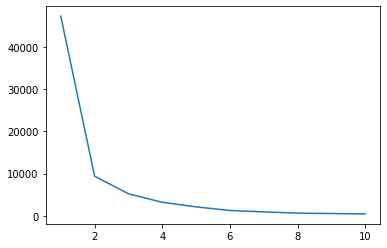

In [ ]:
#initialize the clusters
inertia = []
K = range(1,11)
for k in K:
    kmeanModel = KMeans(n_clusters=k)
    kmeanModel.fit(df_scaled)
    inertia.append(kmeanModel.inertia_)
sns.lineplot(K, inertia)

/usr/local/lib/python3.6/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


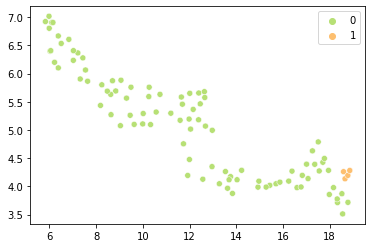

In [ ]:
#visualization of the clusters
clusterer = KMeans(n_clusters=2)
clusterer.fit(df_scaled)
sns.scatterplot(df_reduced[:,0], df_reduced[:,1],hue = clusterer.labels_, palette = "RdYlGn_r")

In [ ]:
#display the outstanding companies according to the clustering
df_for_clustering["cluster"] = clusterer.labels_
df_for_clustering[df_for_clustering["cluster"]==1]

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


date,2019-01-02 00:00:00,2019-01-03 00:00:00,2019-01-04 00:00:00,2019-01-07 00:00:00,2019-01-08 00:00:00,2019-01-09 00:00:00,2019-01-10 00:00:00,2019-01-11 00:00:00,2019-01-14 00:00:00,2019-01-15 00:00:00,2019-01-16 00:00:00,2019-01-17 00:00:00,2019-01-18 00:00:00,2019-01-22 00:00:00,2019-01-23 00:00:00,2019-01-24 00:00:00,2019-01-25 00:00:00,2019-01-28 00:00:00,2019-01-29 00:00:00,2019-01-30 00:00:00,2019-01-31 00:00:00,2019-02-01 00:00:00,2019-02-04 00:00:00,2019-02-05 00:00:00,2019-02-06 00:00:00,2019-02-07 00:00:00,2019-02-08 00:00:00,2019-02-11 00:00:00,2019-02-12 00:00:00,2019-02-13 00:00:00,2019-02-14 00:00:00,2019-02-15 00:00:00,2019-02-19 00:00:00,2019-02-20 00:00:00,2019-02-21 00:00:00,2019-02-22 00:00:00,2019-02-25 00:00:00,2019-02-26 00:00:00,2019-02-27 00:00:00,2019-02-28 00:00:00,...,2020-10-05 00:00:00,2020-10-06 00:00:00,2020-10-07 00:00:00,2020-10-08 00:00:00,2020-10-09 00:00:00,2020-10-12 00:00:00,2020-10-13 00:00:00,2020-10-14 00:00:00,2020-10-15 00:00:00,2020-10-16 00:00:00,2020-10-19 00:00:00,2020-10-20 00:00:00,2020-10-21 00:00:00,2020-10-22 00:00:00,2020-10-23 00:00:00,2020-10-26 00:00:00,2020-10-27 00:00:00,2020-10-28 00:00:00,2020-10-29 00:00:00,2020-10-30 00:00:00,2020-11-02 00:00:00,2020-11-03 00:00:00,2020-11-04 00:00:00,2020-11-05 00:00:00,2020-11-06 00:00:00,2020-11-09 00:00:00,2020-11-10 00:00:00,2020-11-11 00:00:00,2020-11-12 00:00:00,2020-11-13 00:00:00,2020-11-16 00:00:00,2020-11-17 00:00:00,2020-11-18 00:00:00,2020-11-19 00:00:00,2020-11-20 00:00:00,2020-11-23 00:00:00,2020-11-24 00:00:00,2020-11-25 00:00:00,2020-11-27 00:00:00,cluster
GOOGL,1054.680054,1025.469971,1078.069946,1075.920044,1085.369995,1081.650024,1078.829956,1064.469971,1051.510010,1086.510010,1089.510010,1099.119995,1107.300049,1078.630005,1084.410034,1084.000000,1101.510010,1079.859985,1070.060059,1097.989990,1125.890015,1118.619995,1141.420044,1151.869995,1122.890015,1105.910034,1102.380005,1102.119995,1127.579956,1128.630005,1129.199951,1119.630005,1126.510010,1120.589966,1104.209961,1116.560059,1117.329956,1122.010010,1122.890015,1126.550049,...,1482.829956,1451.020020,1459.140015,1483.430054,1510.449951,1564.589966,1567.069946,1563.439941,1555.469971,1567.699951,1529.949951,1551.079956,1585.989990,1606.660034,1632.979980,1584.290039,1598.880005,1510.800049,1556.880005,1616.109985,1624.319946,1645.660034,1745.849976,1762.500000,1759.729980,1761.420044,1737.719971,1747.229980,1742.819946,1772.260010,1774.030029,1761.660034,1740.640015,1758.569946,1736.380005,1727.560059,1763.900024,1764.130005,1787.020020,1
GOOG,1045.849976,1016.059998,1070.709961,1068.390015,1076.280029,1074.660034,1070.329956,1057.189941,1044.689941,1077.150024,1080.969971,1089.900024,1098.260010,1070.520020,1075.569946,1073.900024,1090.989990,1070.079956,1060.619995,1089.060059,1116.369995,1110.750000,1132.800049,1145.989990,1115.229980,1098.709961,1095.060059,1095.010010,1121.369995,1120.160034,1121.670044,1113.650024,1118.560059,1113.800049,1096.969971,1110.369995,1109.400024,1115.130005,1116.050049,1119.920044,...,1486.020020,1453.439941,1460.290039,1485.930054,1515.219971,1569.150024,1571.680054,1568.079956,1559.130005,1573.010010,1534.609985,1555.930054,1593.310059,1615.329956,1641.000000,1590.449951,1604.260010,1516.619995,1567.239990,1621.010010,1626.030029,1650.209961,1749.130005,1763.369995,1761.750000,1763.000000,1740.390015,1752.709961,1749.839966,1777.020020,1781.380005,1770.150024,1746.780029,1763.920044,1742.189941,1734.859985,1768.880005,1771.430054,1793.189941,1
AMZN,1539.130005,1500.280029,1575.390015,1629.510010,1656.579956,1659.420044,1656.219971,1640.560059,1617.209961,1674.560059,1683.780029,1693.219971,1696.199951,1632.170044,1640.020020,1654.930054,1670.569946,1637.890015,1593.880005,1670.430054,1718.729980,1626.229980,1633.310059,1658.810059,1640.260010,1614.369995,1588.219971,1591.000000,1638.010010,1640.000000,1622.650024,1607.949951,1627.579956,1622.099976,1619.439941,1631.560059,1633.000000,1636.400024,1641.089966,1639.829956

In [ ]:
df_for_clustering[df_for_clustering["cluster"]==1].describe()

date,2019-01-02 00:00:00,2019-01-03 00:00:00,2019-01-04 00:00:00,2019-01-07 00:00:00,2019-01-08 00:00:00,2019-01-09 00:00:00,2019-01-10 00:00:00,2019-01-11 00:00:00,2019-01-14 00:00:00,2019-01-15 00:00:00,2019-01-16 00:00:00,2019-01-17 00:00:00,2019-01-18 00:00:00,2019-01-22 00:00:00,2019-01-23 00:00:00,2019-01-24 00:00:00,2019-01-25 00:00:00,2019-01-28 00:00:00,2019-01-29 00:00:00,2019-01-30 00:00:00,2019-01-31 00:00:00,2019-02-01 00:00:00,2019-02-04 00:00:00,2019-02-05 00:00:00,2019-02-06 00:00:00,2019-02-07 00:00:00,2019-02-08 00:00:00,2019-02-11 00:00:00,2019-02-12 00:00:00,2019-02-13 00:00:00,2019-02-14 00:00:00,2019-02-15 00:00:00,2019-02-19 00:00:00,2019-02-20 00:00:00,2019-02-21 00:00:00,2019-02-22 00:00:00,2019-02-25 00:00:00,2019-02-26 00:00:00,2019-02-27 00:00:00,2019-02-28 00:00:00,...,2020-10-05 00:00:00,2020-10-06 00:00:00,2020-10-07 00:00:00,2020-10-08 00:00:00,2020-10-09 00:00:00,2020-10-12 00:00:00,2020-10-13 00:00:00,2020-10-14 00:00:00,2020-10-15 00:00:00,2020-10-16 00:00:00,2020-10-19 00:00:00,2020-10-20 00:00:00,2020-10-21 00:00:00,2020-10-22 00:00:00,2020-10-23 00:00:00,2020-10-26 00:00:00,2020-10-27 00:00:00,2020-10-28 00:00:00,2020-10-29 00:00:00,2020-10-30 00:00:00,2020-11-02 00:00:00,2020-11-03 00:00:00,2020-11-04 00:00:00,2020-11-05 00:00:00,2020-11-06 00:00:00,2020-11-09 00:00:00,2020-11-10 00:00:00,2020-11-11 00:00:00,2020-11-12 00:00:00,2020-11-13 00:00:00,2020-11-16 00:00:00,2020-11-17 00:00:00,2020-11-18 00:00:00,2020-11-19 00:00:00,2020-11-20 00:00:00,2020-11-23 00:00:00,2020-11-24 00:00:00,2020-11-25 00:00:00,2020-11-27 00:00:00,cluster
count,4.000000,4.000000,4.000000,4.000000,4.000000,4.000000,4.000000,4.000000,4.000000,4.000000,4.000000,4.000000,4.000000,4.000000,4.000000,4.000000,4.000000,4.000000,4.000000,4.000000,4.000000,4.000000,4.000000,4.000000,4.000000,4.000000,4.000000,4.000000,4.000000,4.000000,4.000000,4.000000,4.000000,4.000000,4.000000,4.000000,4.000000,4.000000,4.000000,4.000000,...,4.000000,4.000000,4.000000,4.000000,4.000000,4.000000,4.000000,4.000000,4.000000,4.000000,4.000000,4.000000,4.000000,4.000000,4.000000,4.000000,4.000000,4.000000,4.000000,4.000000,4.000000,4.000000,4.000000,4.000000,4.000000,4.000000,4.000000,4.000000,4.000000,4.000000,4.000000,4.000000,4.000000,4.000000,4.000000,4.000000,4.000000,4.000000,4.000000,4.0
mean,1340.339996,1301.232498,1360.429993,1371.410004,1376.287506,1366.305023,1370.677460,1357.027496,1351.572479,1384.132538,1383.707489,1401.687500,1415.505005,1372.575012,1386.077515,1402.125031,1416.317474,1400.357483,1383.340027,1419.045013,1448.450012,1423.139984,1442.130035,1464.732513,1446.327515,1424.012512,1414.187500,1413.282501,1445.562500,1452.190002,1443.962494,1443.699982,1452.037506,1445.665009,1431.732483,1442.252533,1437.440002,1447.317505,1446.507507,1395.835022,...,1968.709991,1928.532471,1968.492493,1987.180054,2032.552460,2105.417480,2090.837463,2056.957458,2038.839966,2020.322479,1981.197479,1998.932495,2016.567505,2047.602478,2075.482483,2032.767517,2046.795013,1948.812531,1991.347504,1973.942474,1964.739990,2003.464966,2112.364960,2154.045013,2154.150024,2196.600006,2130.142487,2159.337463,2141.464996,2182.740051,2199.020050,2187.179993,2159.369995,2162.619995,2142.684967,2145.162476,2188.572510,2196.107544,2207.054993,1.0
std,343.161215,330.631117,335.364199,347.193497,341.415639,332.763885,342.030148,342.188659,351.789936,349.224423,344.660707,354.947921,362.068294,345.542457,356.012907,377.590275,373.493113,382.532331,377.551705,380.738277,380.835046,366.429823,364.282401,377.966557,393.277640,386.651862,382.148925,380.241893,385.358959,395.400921,385.131080,400.376889,400.718727,399.091686,399.914536,396.372462,388.656710,396.373539,392.821460,315.648255,...,826.997908,790.328351,830.195407,814.957182,848.344328,901.264668,907.362849,874.713407,869.225930,836.192314,819.323252,813.963652,780.720145,757.362923,757.739618,786.564749,827.601481,810.459757,813.754672,708.143547,693.231335,696.707162,752.703535,778.640861,771.5

In [ ]:
df_for_clustering[df_for_clustering["cluster"]==0].describe()

date,2019-01-02 00:00:00,2019-01-03 00:00:00,2019-01-04 00:00:00,2019-01-07 00:00:00,2019-01-08 00:00:00,2019-01-09 00:00:00,2019-01-10 00:00:00,2019-01-11 00:00:00,2019-01-14 00:00:00,2019-01-15 00:00:00,2019-01-16 00:00:00,2019-01-17 00:00:00,2019-01-18 00:00:00,2019-01-22 00:00:00,2019-01-23 00:00:00,2019-01-24 00:00:00,2019-01-25 00:00:00,2019-01-28 00:00:00,2019-01-29 00:00:00,2019-01-30 00:00:00,2019-01-31 00:00:00,2019-02-01 00:00:00,2019-02-04 00:00:00,2019-02-05 00:00:00,2019-02-06 00:00:00,2019-02-07 00:00:00,2019-02-08 00:00:00,2019-02-11 00:00:00,2019-02-12 00:00:00,2019-02-13 00:00:00,2019-02-14 00:00:00,2019-02-15 00:00:00,2019-02-19 00:00:00,2019-02-20 00:00:00,2019-02-21 00:00:00,2019-02-22 00:00:00,2019-02-25 00:00:00,2019-02-26 00:00:00,2019-02-27 00:00:00,2019-02-28 00:00:00,...,2020-10-05 00:00:00,2020-10-06 00:00:00,2020-10-07 00:00:00,2020-10-08 00:00:00,2020-10-09 00:00:00,2020-10-12 00:00:00,2020-10-13 00:00:00,2020-10-14 00:00:00,2020-10-15 00:00:00,2020-10-16 00:00:00,2020-10-19 00:00:00,2020-10-20 00:00:00,2020-10-21 00:00:00,2020-10-22 00:00:00,2020-10-23 00:00:00,2020-10-26 00:00:00,2020-10-27 00:00:00,2020-10-28 00:00:00,2020-10-29 00:00:00,2020-10-30 00:00:00,2020-11-02 00:00:00,2020-11-03 00:00:00,2020-11-04 00:00:00,2020-11-05 00:00:00,2020-11-06 00:00:00,2020-11-09 00:00:00,2020-11-10 00:00:00,2020-11-11 00:00:00,2020-11-12 00:00:00,2020-11-13 00:00:00,2020-11-16 00:00:00,2020-11-17 00:00:00,2020-11-18 00:00:00,2020-11-19 00:00:00,2020-11-20 00:00:00,2020-11-23 00:00:00,2020-11-24 00:00:00,2020-11-25 00:00:00,2020-11-27 00:00:00,cluster
count,94.000000,94.000000,94.000000,94.000000,94.000000,94.000000,94.000000,94.000000,94.000000,94.000000,94.000000,94.000000,94.000000,94.000000,94.000000,94.000000,94.000000,94.000000,94.000000,94.000000,94.000000,94.000000,94.000000,94.000000,94.000000,94.000000,94.000000,94.000000,94.000000,94.000000,94.000000,94.000000,94.000000,94.000000,94.000000,94.000000,94.000000,94.000000,94.000000,94.000000,...,94.000000,94.000000,94.000000,94.000000,94.000000,94.000000,94.000000,94.000000,94.000000,94.000000,94.000000,94.000000,94.000000,94.000000,94.000000,94.000000,94.000000,94.000000,94.000000,94.000000,94.000000,94.000000,94.000000,94.000000,94.000000,94.000000,94.000000,94.000000,94.000000,94.000000,94.000000,94.000000,94.000000,94.000000,94.000000,94.000000,94.000000,94.000000,94.000000,94.0
mean,106.282923,103.481783,108.024881,109.768892,110.571633,112.268850,113.123247,113.086171,111.930501,113.836352,113.570936,114.862720,116.402990,114.361920,114.159370,115.535276,117.014309,115.718664,115.085555,117.000749,118.885120,119.288107,120.107606,120.748228,120.650255,119.321841,119.984427,120.404910,122.654677,122.468491,122.796592,123.985606,123.901065,124.014269,123.164420,124.228648,124.622979,124.359582,125.197876,125.303342,...,193.424787,190.930320,195.105212,196.166596,198.928192,202.809361,204.182234,202.281701,200.809947,201.062020,198.271595,198.636277,197.122447,197.968191,199.231703,195.730319,196.064627,190.177765,192.584361,187.340425,188.670213,192.371489,201.347340,206.485852,207.374042,201.742979,197.537340,202.091701,200.731915,202.964149,203.713299,203.104789,201.788723,204.158086,203.847446,204.895531,206.099150,207.361809,210.068831,0.0
std,87.267670,85.859697,89.895681,91.197318,91.193149,93.819969,94.484273,94.279012,93.327959,95.631988,95.374886,97.171012,97.828426,95.722900,95.113526,95.650241,95.516168,94.209356,93.907003,95.269573,97.796558,97.971818,98.518611,98.623002,97.939093,96.524064,97.044286,97.778028,100.055693,99.330402,99.931566,101.486464,101.542210,101.699659,100.780489,101.937701,101.941499,101.663054,104.134413,104.399375,...,177.438986,175.098196,180.767807,182.135189,185.596500,188.980931,193.185181,190.140764,190.123325,191.020741,189.575770,192.033259,188.715725,189.198233,191.220143,187.371867,187.706834,183.391811,185.827259,177.746254,178.793508,182.010388,192.536760,202.345443,205.652655,192.644412,184.048309,1

In [ ]:
df.head()

,ATVI,ADBE,AMD,ALXN,ALGN,GOOGL,GOOG,AMZN,AEP,AMGN,ADI,ANSS,AAPL,AMAT,ASML,TEAM,ADSK,ADP,BIDU,BIIB,BKNG,AVGO,CDNS,CDW,CERN,CHTR,CHKP,CTAS,CSCO,CTSH,CMCSA,CPRT,COST,CSX,DXCM,DOCU,DLTR,EBAY,EA,EXC,...,MCHP,MU,MSFT,MRNA,MDLZ,MNST,NTES,NFLX,NVDA,NXPI,ORLY,OKTA,PCAR,PAYX,PYPL,PTON,PEP,PDD,QCOM,REGN,ROST,SGEN,SIRI,SWKS,SPLK,SBUX,SNPS,TMUS,TSLA,TXN,TCOM,VRSN,VRSK,VRTX,WBA,WDAY,XEL,XLNX,ZM,average
date,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
2019-01-02,47.029999,224.570007,18.830000,98.050003,202.119995,1054.680054,1045.849976,1539.130005,72.940002,191.899994,85.919998,143.009995,39.480000,33.480000,156.300003,89.029999,128.960007,130.139999,162.250000,304.690002,1721.699951,253.509995,43.230000,79.169998,51.869999,287.989990,103.500000,167.490005,42.950001,63.090000,34.369999,47.680000,204.759995,61.950001,115.180000,40.820000,91.199997,28.850000,80.370003,44.070000,...,71.349998,32.750000,101.120003,15.330000,39.889999,48.759998,45.948002,267.660004,136.220001,75.029999,341.149994,63.259998,57.860001,65.070000,85.750000,NaN,109.279999,22.209999,57.400002,372.440002,83.779999,57.490002,5.90,67.959999,103.320000,64.320000,84.050003,65.260002,62.023998,94.449997,27.590000,147.759995,108.650002,164.080002,68.040001,159.740005,48.220001,86.849998,NaN,156.652599
2019-01-03,45.360001,215.699997,17.049999,100.209999,184.779999,1025.469971,1016.059998,1500.280029,72.769997,188.979996,80.730003,137.639999,35.547501,31.540001,147.679993,84.480003,121.849998,126.209999,154.710007,307.000000,1663.119995,230.960007,41.529999,77.129997,50.700001,287.500000,102.349998,164.809998,41.070000,61.099998,34.639999,46.889999,200.419998,60.980000,112.260002,38.830002,90.760002,28.320000,78.709999,44.119999,...,66.320000,31.000000,97.400002,15.500000,39.740002,48.000000,44.180000,271.200012,127.989998,71.970001,346.130005,59.560001,56.520000,63.970001,82.089996,NaN,108.260002,21.520000,55.700001,372.079987,83.080002,56.369999,5.94,60.720001,100.809998,61.529999,81.110001,65.019997,60.071999,88.879997,26.959999,142.589996,105.330002,163.729996,67.330002,154.020004,48.029999,83.580002,NaN,152.369567
2019-01-04,47.169998,226.190002,19.000000,106.000000,186.710007,1078.069946,1070.709961,1575.390015,73.440002,195.440002,82.690002,143.660004,37.064999,33.700001,154.070007,87.089996,128.279999,131.240005,160.949997,318.329987,1717.550049,233.229996,43.259998,77.879997,52.230000,302.739990,105.349998,172.559998,42.919998,63.700001,35.810001,48.560001,206.240005,62.790001,116.239998,40.900002,92.889999,28.969999,84.419998,44.619999,...,69.010002,32.700001,101.930000,16.959999,40.840000,49.790001,45.950001,297.570007,136.190002,75.449997,341.820007,63.150002,59.029999,66.199997,86.269997,NaN,110.480003,22.690001,56.599998,397.549988,85.339996,59.540001,6.17,63.630001,108.040001,63.570000,83.900002,67.489998,63.537998,92.900002,28.549999,148.970001,109.980003,172.699997,69.570000,163.350006,48.500000,87.449997,NaN,159.143457
2019-01-07,48.500000,229.259995,20.570000,107.940002,189.919998,1075.920044,1068.390015,1629.510010,73.029999,198.070007,83.209999,147.320007,36.982498,34.299999,157.589996,92.709999,132.720001,130.529999,162.600006,322.399994,1711.819946,237.979996,43.419998,77.570000,51.930000,301.470001,104.870003,172.850006,43.209999,63.599998,35.430000,48.830002,207.000000,62.450001,129.949997,41.689999,97.959999,29.469999,87.589996,44.700001,...,71.029999,34.000000,102.059998,16.270000,41.119999,49.730000,47.897999,315.339996,143.399994,76.010002,339.690002,66.269997,58.959999,65.849998,86.930000,NaN,109.529999,23.209999,56.439999,396.630005,88.930000,62.919998,6.22,64.489998,112.900002,63.570000,85.760002,68.440002,66.991997,94.500000,29.180000,151.399994,110.089996,175.850006,69.970001,163.500000,48.290001,89.760002,NaN,161.264447
2019-01-08,49.970001,232.679993,20.750000,108.610001,192.949997,1085.369995,1076.280029,1656.579956,73.930000,200.610001,85.239998,148.050003,37.687500,32.910000,156.429993,94.820000,133.8

In [ ]:
#get the desired company
df_out=df.loc[:,['TSLA','GOOGL','ALXN','AMZN']]

In [ ]:
#save csv
df_out.to_csv("yf_chosen_comp.csv")